In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telugu-6-vowel-dataset/CSV_datasetsix_vowel_dataset_with_class.csv
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/473.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/537.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/521.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/436.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/539.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/516.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/474.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/501.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/429.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/544.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/489.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/576.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/476.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/446.jpg
/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/E/425.jpg
/kag

In [3]:
#Imports + Environment setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report



In [4]:
#Dataset verification
base_path = '/kaggle/input/telugu-6-vowel-dataset/Vowel_Dataset/'
csv_path = '/kaggle/input/telugu-6-vowel-dataset/CSV_datasetsix_vowel_dataset_with_class.csv'

# Check dataset
class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print("Classes:", class_dirs)

for c in class_dirs:
    print(c, len(os.listdir(os.path.join(base_path, c))))

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(df.head())

Classes: ['E', 'U', 'A', 'Ai', 'Aa', 'Ee']
E 200
U 200
A 200
Ai 200
Aa 200
Ee 200
   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     255     255     254     255     255     255     252     255     255   
1     255     255     254     255     255     254     255     255     255   
2     255     254     255     255     255     255     254     255     254   
3     254     255     255     255     254     255     255     255     254   
4     254     255     255     253     255     255     255     254     255   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     255  ...       255       255       255       255       255       255   
1     255  ...       255       255       255       255       255       255   
2     255  ...       255       255       255       255       255       255   
3     255  ...       255       255       255       255       255       255   
4     255  ...       255       255       255       255       255 

In [5]:
#Data Generators (train/validation split + augmentation)
IMG_SIZE = (64, 64)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = val_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [6]:
#Model building + compilation
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1756115147.403248      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756115147.403893      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756115160.120880     117 service.cc:148] XLA service 0x7a5894002d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756115160.121800     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756115160.121821     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756115161.575842     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/60 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.1771 - loss: 1.9527 

I0000 00:00:1756115165.084909     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.3050 - loss: 1.7188 - val_accuracy: 0.7583 - val_loss: 0.8611
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5599 - loss: 1.1429 - val_accuracy: 0.7167 - val_loss: 0.6772
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6384 - loss: 0.9627 - val_accuracy: 0.8333 - val_loss: 0.4947
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6915 - loss: 0.8154 - val_accuracy: 0.8333 - val_loss: 0.4473
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7515 - loss: 0.6822 - val_accuracy: 0.9042 - val_loss: 0.3570
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7303 - loss: 0.6914 - val_accuracy: 0.9083 - val_loss: 0.3413
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7724 - loss: 0.6254 - val_accuracy: 0.8500 - val_loss: 0.3578
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7497 - loss: 0.6388 - val_accuracy: 0.8833 - val_loss: 

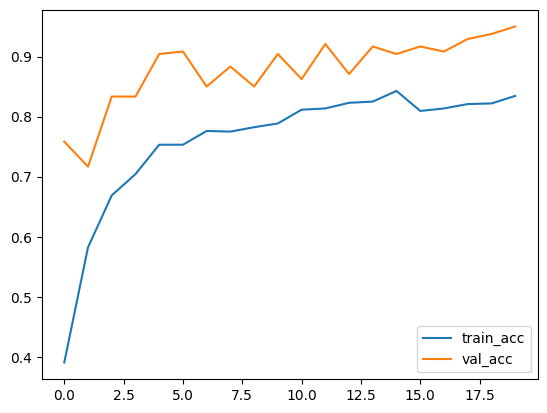

In [7]:
#Training + Plots
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict
)

# Accuracy/Loss plots
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9297 - loss: 0.2058
Validation Accuracy: 0.95
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
              precision    recall  f1-score   support

           A       0.84      0.93      0.88        40
          Aa       0.97      0.82      0.89        40
          Ai       1.00      1.00      1.00        40
           E       0.95      1.00      0.98        40
          Ee       0.97      0.97      0.97        40
           U       0.97      0.97      0.97        40

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



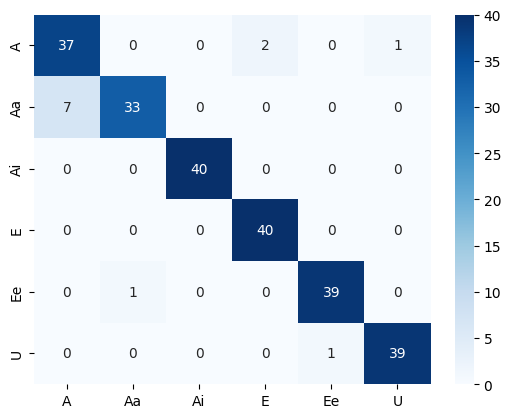

In [8]:
#Evaluation + Confusion Matrix + Classification Report
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.show()


In [9]:
model.save('telugu_vowel_model.h5')
